In [381]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import clip
from scripts.clip_wrapper import ClipWrapper
from scripts.plot import visualize_vandt_heatmap
from scripts.methods import vision_heatmap_iba, text_heatmap_iba
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import math



os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [271]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T


class NIHSingleLabelBBoxDataset(Dataset):
    def __init__(self, csv_path, images_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform

        # Get sorted list of unique labels
        self.label_list = sorted(self.df['Finding Label'].unique())
        self.label_to_idx = {label: i for i, label in enumerate(self.label_list)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image Index']
        label = row['Finding Label']
        bbox = [row['Bbox [x'], row['y'], row['w'], row['h]']]

        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_idx = self.label_to_idx[label]
        # return image, label_idx, bbox
        return image, label, bbox, img_name

In [272]:
def plot(model, image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9, bb=None, ):
    # Preprocess image
    image = Image.open(image).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device) # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)
    return vmap

# Conceptual Captions

Conceptual Caption provides a large amount of images and their raw descriptions collected from the web. The examples below are from its validation split.

# MS-CXR

The MS-CXR dataset is a radiology dataset that provides 1162 image–sentence pairs of bounding boxes and corresponding phrases. Please download the dataset from https://physionet.org/content/ms-cxr/0.1/. We provide two examples below for illustration purpose.
- To be able to run the following code, you need to first download checkpoint finetuned on xray data from https://github.com/rajpurkarlab/CXR-RePaiR.

In [273]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


med_model, med_preprocess= clip.load("ViT-B/32", device=device)
med_model.load_state_dict(torch.load("../data/clip-imp-pretrained_128_6_after_4.pt", map_location=device))
med_model1 = ClipWrapper(med_model)

(1024, 1024)
<PIL.Image.Image image mode=RGB size=1024x1024 at 0x1A14B79A0>
[131.796610169492, 706.476843882415, 221.28813559322, 123.661016949153]
Atelectasis
imageSize <class 'PIL.Image.Image'>
Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

<class 'numpy.ndarray'>


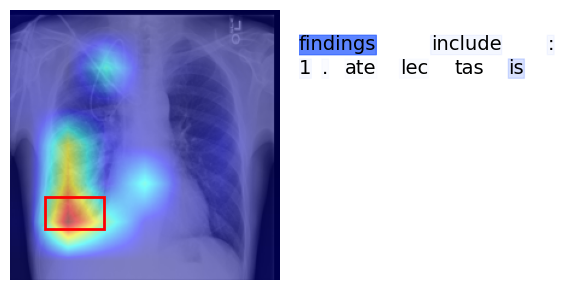

In [282]:
dataset = NIHSingleLabelBBoxDataset(
    csv_path='../data/BBox_List_2017.csv',
    images_dir='../data/images',
    transform=None
)

image_dir = '../data/images'
image, label, bbox, img_name = dataset[16]
print(image.size)
print(image)
print(bbox)
print(label)
print("imageSize",type(image))
import os
full_path = os.path.join(image_dir, img_name)
img = full_path
text = 'findings include: 1. ' + label
bb = [(bbox[0],bbox[1],bbox[2],bbox[3])]
vmap_original = plot(med_model1, img, text,vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)
# vmap = plot(med_model, img, "a chest X-ray",vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=bb)
print(type(vmap_original))



Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]

aaaaaaaaaaaaaaa (224, 224)


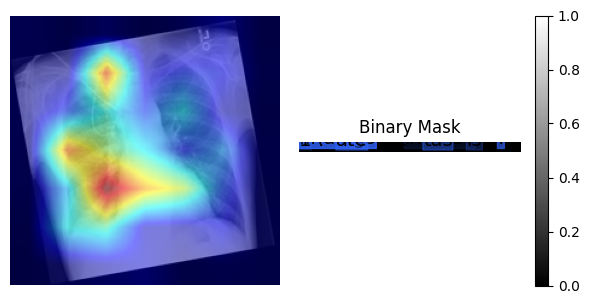

In [309]:
from PIL import Image, ImageOps
from PIL import Image
import cv2
import numpy as np


def plot_transformation(model, image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9, bb=None, ):
      # Preprocess image
    # image = Image.open(image).convert('RGB')
    image_feat = processor(images=image, return_tensors="pt")['pixel_values'].to(device) # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    image_under = processor(images=image, return_tensors="pt", do_normalize=False)['pixel_values'][0].permute(1,2,0) # no normalization
    if bb:
        scaled_bb = []
        for x, y, w, h in bb:
            hr, vr = image_under.shape[0]/image.size[0], image_under.shape[1]/image.size[1]
            scaled_bb.append((x*hr, y*vr, w*hr, h*vr))
        bb = scaled_bb
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under, bb=bb)
    return vmap


image = Image.open(img).convert('RGB')
rotated_image = image.rotate(10, expand=True)

text = 'findings include: 1. ' + label
vmap_rotate = plot_transformation(med_model1, rotated_image, text,vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7, bb=None)


print("aaaaaaaaaaaaaaa",vmap_rotate.shape)








In [ ]:
image_width, image_height = image.size
assert image_width == image_height


def bbox_to_mask(bbox, W, H):
    mask = np.zeros((W, H), dtype=np.uint8)
    x1, x2 = int(bbox[0]), int(bbox[0] + bbox[2])
    y1, y2 = int(bbox[1]), int(bbox[1] + bbox[3])
    mask[y1:y2, x1:x2] = 1
    return mask

mask_bb_numpy = bbox_to_mask(bbox, image_width, image_height)
mask_bb_image = Image.fromarray(mask_bb_numpy, mode='L')
rotated_mask_bb_image  = mask_bb_image.rotate(10, expand=True)
# rotated_mask_bb_resized = rotated_mask_bb_image.resize()


plt.imshow(rotated_mask_bb_image, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()

In [160]:
# class NIHSingleLabelBBoxDataset(Dataset):
#     def __init__(self, csv_path, images_dir):
#         self.df = pd.read_csv(csv_path)
#         self.images_dir = images_dir

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         image_fileName = row['Image Index']
#         image_path = self.images_dir + '/' + image_fileName
#         image_id = os.path.splitext(image_fileName)[0]
#         label = row['Finding Label']
#         bbox = [row['Bbox [x'], row['y'], row['w'], row['h]']]
#         return image_id, image_path, label, bbox

# data_dir = "../data"
# dataset = NIHSingleLabelBBoxDataset(
#     csv_path = data_dir + '/BBox_List_2017.csv',
#     images_dir = data_dir + '/images'
# )

# image_id, image_path, label, bbox = dataset[16]

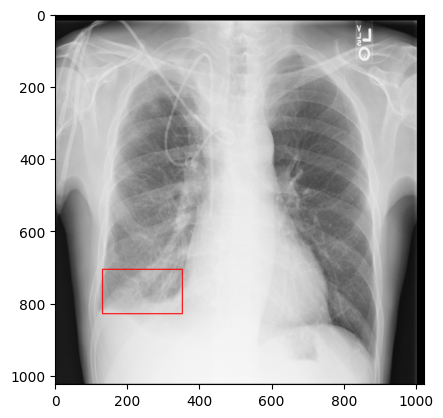

In [161]:
image = Image.open('../data/images/00007557_026.png').convert('RGB')
image_width, image_height = image.size
assert image_width == image_height

def bbox_to_mask(bbox, W, H):
    mask = np.zeros((W, H), dtype=np.uint8)
    x1, x2 = int(bbox[0]), int(bbox[0] + bbox[2])
    y1, y2 = int(bbox[1]), int(bbox[1] + bbox[3])
    mask[y1:y2, x1:x2] = 1
    return mask


mask = bbox_to_mask(bbox, image_width, image_height)
contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_contour = np.array(image).copy()
cv2.drawContours(image_with_contour, contours, -1, (0, 0, 255), thickness=2)  # Red line (BGR)
plt.imshow(cv2.cvtColor(image_with_contour, cv2.COLOR_BGR2RGB))

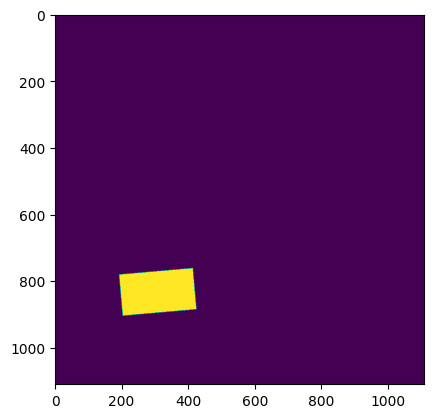

In [267]:
rot_image = image.rotate(20, expand=True)
rot_mask_image = Image.fromarray(mask, mode='L').rotate(5, expand=True)#.resize((224, 224), resample=Image.LANCZOS)
rot_mask = np.array(rot_mask_image)
plt.imshow(rot_mask_image)
# rot_contours, _ = cv2.findContours((rot_mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# rot_image_with_contour = np.array(rot_image).copy()
# cv2.drawContours(rot_image_with_contour, rot_contours, -1, (0, 0, 255), thickness=2)  # Red line (BGR)
# plt.imshow(cv2.cvtColor(rot_image_with_contour, cv2.COLOR_BGR2RGB))


Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


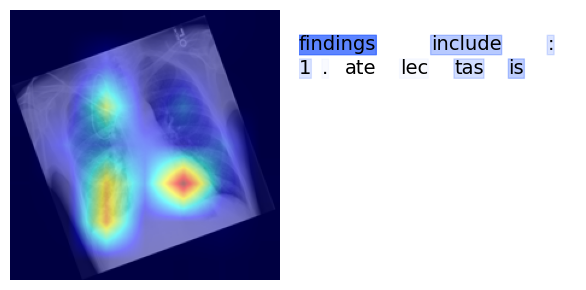

In [268]:
text = 'findings include: 1. ' + label
vmap = plot_transformation(med_model1, rot_image , text, vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7)

In [400]:
res.keys()

dict_keys(['vmap_array', 'bbox_mask', 'image'])

In [394]:
res['vmap_array'].shape

(3, 224, 224)

In [412]:
with open('../out/00007557_026-rot-0-crp-0.pkl', 'rb') as f:
    res = pickle.load(f)
    
heatmap = res['vmap_array'][2]

# Convert heatmap to RGBA using a colormap (e.g., 'jet', 'plasma', 'coolwarm')
colormap = cm.get_cmap('jet')
heatmap_rgba = colormap(heatmap)  # shape (H, W, 4), float32 in [0,1]
heatmap_rgba[..., 3] = 0.5  # set alpha channel to 0.5 for transparency

# Convert to uint8 and then to PIL
heatmap_uint8 = (heatmap_rgba * 255).astype(np.uint8)

# Convert base image to RGBA
heatmap_pil = Image.fromarray(heatmap_uint8, mode="RGBA")

# Overlay on the original image
overlay = res['image'].resize(heatmap.shape, resample=Image.LANCZOS).convert("RGBA")
composite = Image.alpha_composite(overlay, heatmap_pil)

# Convert mask to format for contour detection (0–255)
mask_for_cv = (res['bbox_mask'] * 255).astype(np.uint8)

# Find contours using OpenCV
contours, _ = cv2.findContours(mask_for_cv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert composite image to draw-ready format
composite_draw = composite.copy()
draw = ImageDraw.Draw(composite_draw)

# Draw contours
for cnt in contours:
    points = [(int(p[0][0]), int(p[0][1])) for p in cnt]
    draw.line(points + [points[0]], fill=(255, 0, 0, 255), width=1)


composite_draw.show()

In [344]:

# crp_rot_image
# vmap = plot_transformation(med_model1, crp_rot_image , text, vbeta = 1, vvar=1, vlayer=9, tbeta=1, tvar=1, tlayer=7)

In [345]:
type(image)

PIL.Image.Image

In [15]:


def rescale_bbox_to_224(bbox, orig_width, orig_height):
    x, y, w, h = bbox
    x_new = x * (224 / orig_width)
    y_new = y * (224 / orig_height)
    w_new = w * (224 / orig_width)
    h_new = h * (224 / orig_height)
    return [x_new, y_new, w_new, h_new]


def threshold_heatmap(vmap, threshold=0.5):
    vmap_norm = (vmap - vmap.min()) / (vmap.max() - vmap.min())
    return (vmap_norm > threshold).float()


def bbox_to_mask(bbox):
    mask = torch.zeros((224, 224))
    x1, x2 = int(bbox[0]), int(bbox[0] + bbox[2])
    y1, y2 = int(bbox[1]), int(bbox[1] + bbox[3])
    mask[y1:y2, x1:x2] = 1
    return mask


new_bbox = rescale_bbox_to_224(bbox, 1024, 1024)
bbox_mask = bbox_to_mask(new_bbox)
v_map = torch.from_numpy(vmap)
vmap_mask = threshold_heatmap(v_map)


def compute_iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    union = ((mask1 + mask2) > 0).float().sum()
    return (intersection / union).item()


def precision(pred_mask, gt_mask):
    tp = (pred_mask * gt_mask).sum()
    predicted_positives = pred_mask.sum()
    return (tp / predicted_positives).item() if predicted_positives > 0 else 0.0


def recall(pred_mask, gt_mask):
    tp = (pred_mask * gt_mask).sum()
    actual_positives = gt_mask.sum()
    return (tp / actual_positives).item() if actual_positives > 0 else 0.0


iou=compute_iou(vmap_mask,bbox_mask)
persision = precision(vmap_mask,bbox_mask)
recall = recall(vmap_mask,bbox_mask)

print("iou",iou)
print("persision",persision)
print("recall", recall)


iou 0.33079180121421814
persision 0.35085538029670715
recall 0.8526077270507812


In [74]:
import torch.nn.functional as F


# med_model = ClipWrapper(med_model)

def get_clip_similarity(model, processor, image_tensor, text):


    print("before procc",image_tensor.size)

    # inputs = processor(images=image_tensor, text=[text], return_tensors="pt").to(device)

    image_tensor = processor(image_tensor).unsqueeze(0).to(device)
    text_tokens = clip.tokenize([text]).to(device)



    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(text_tokens)

    # Normalize (L2)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    # Compute cosine similarity
    similarity = (image_features @ text_features.T).item()



    return similarity


get_clip_similarity(med_model, med_preprocess, image, text )

before procc (1024, 1024)


0.27737075090408325

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
size of image (1024, 1024, 3)
type of image <class 'PIL.Image.Image'>
RGB
size of mask (1024, 1024)


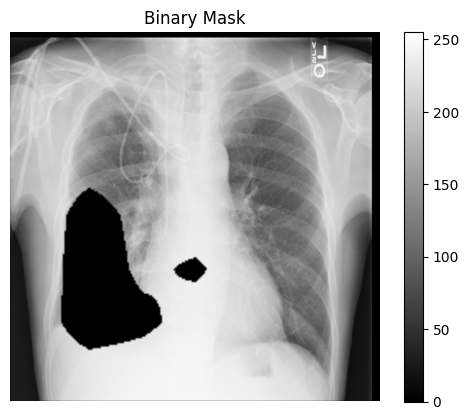

before procc (1024, 1024)


0.29153257608413696

In [47]:
### delete important part of image


# def(image, vmap)

import torch
import numpy as np
import cv2

print(type(vmap_mask))
vmap_mask_numpy = vmap_mask.detach().cpu().numpy()


print(type(vmap_mask_numpy))

print("size of image",np.array(image).shape)

print("type of image",type(image))

print(image.mode)

resized_heatmap = cv2.resize(vmap_mask_numpy, (1024, 1024), interpolation=cv2.INTER_LINEAR)
resized_heatmap = (resized_heatmap - resized_heatmap.min()) / (resized_heatmap.max() - resized_heatmap.min())


print("size of mask",np.array(resized_heatmap).shape)


mask_rgb = np.stack([resized_heatmap]*3, axis=-1) 


# print("size of mask",np.array(mask_rgb).shape)


output = np.array(image) * (1 - mask_rgb)

output = Image.fromarray(output.astype(np.uint8))



import matplotlib.pyplot as plt
# mask_np = resized_heatmap.numpy()
# # Plot
plt.imshow(output, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()


get_clip_similarity(med_model, med_preprocess, output, text)


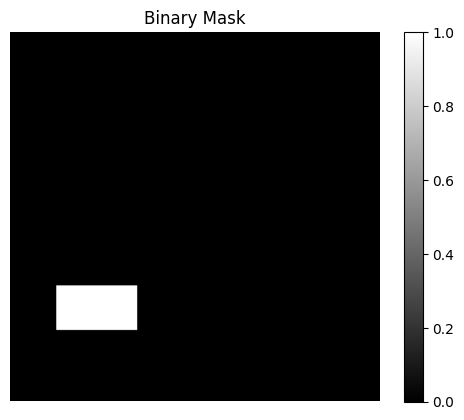

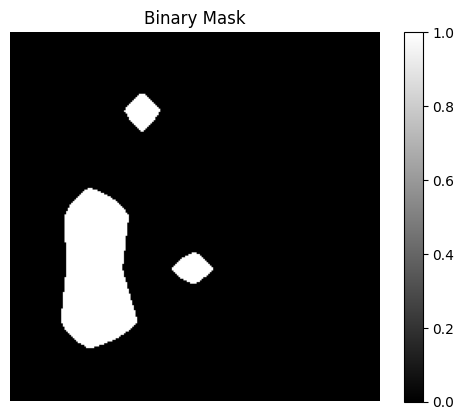

In [231]:
import matplotlib.pyplot as plt

# mask = bbox_to_mask(bbox)

import matplotlib.pyplot as plt
mask1 = mask.numpy()
# Plot
plt.imshow(mask1, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()

mask_np = vmap_mask.numpy()
# Plot
plt.imshow(mask_np, cmap='gray')  # or use cmap='Reds' or 'hot'
plt.title("Binary Mask")
plt.axis('off')
plt.colorbar()
plt.show()


